## Load, process, analyse 

In [308]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

### Load dataset  and look at basic info

In [309]:
dataframe = pd.read_csv('Testovoe_zadanie_dataframe.csv',sep=';',encoding='cp1251')
print(dataframe.head(10),'\n')
total_rows = dataframe.shape[0]
not_null_rows = dataframe['Что-то'].notnull().sum()

print('Total rows: ',total_rows)
print('Not null rows: ',not_null_rows)
print('Null percentage',1 - not_null_rows/total_rows)

data = dataframe['Что-то']
timestamp = dataframe['Time']

print('data range: from', timestamp[0], ' to ',timestamp.iloc[-1])
data.describe()

               Time  Что-то
0  27.07.2022 15:15   718.0
1  27.07.2022 15:30   665.0
2  27.07.2022 15:45   637.0
3  27.07.2022 16:00   661.0
4  27.07.2022 16:15   668.0
5  27.07.2022 16:30   687.0
6  27.07.2022 16:45   692.0
7  27.07.2022 17:00   640.0
8  27.07.2022 17:15   680.0
9  27.07.2022 17:30   678.0 

Total rows:  2881
Not null rows:  2718
Null percentage 0.05657757723012846
data range: from 27.07.2022 15:15  to  26.08.2022 15:15


count    2718.000000
mean      368.701619
std       295.226746
min         0.000000
25%        61.000000
50%       348.000000
75%       668.000000
max       982.000000
Name: Что-то, dtype: float64

* 5 percent of null values - not so much

### Fill NA values + convert to datetime

In [310]:
#pad vs backfill
dataframe.fillna(method="pad",inplace=True)

dataframe.index = pd.to_datetime(dataframe['Time'], errors='coerce', format='%d.%m.%Y %H:%M')
dataframe.drop(columns=['Time'],inplace=True)
assert dataframe.shape == (2881, 1), 'Error, shape of timeseries changed'

### Plotting

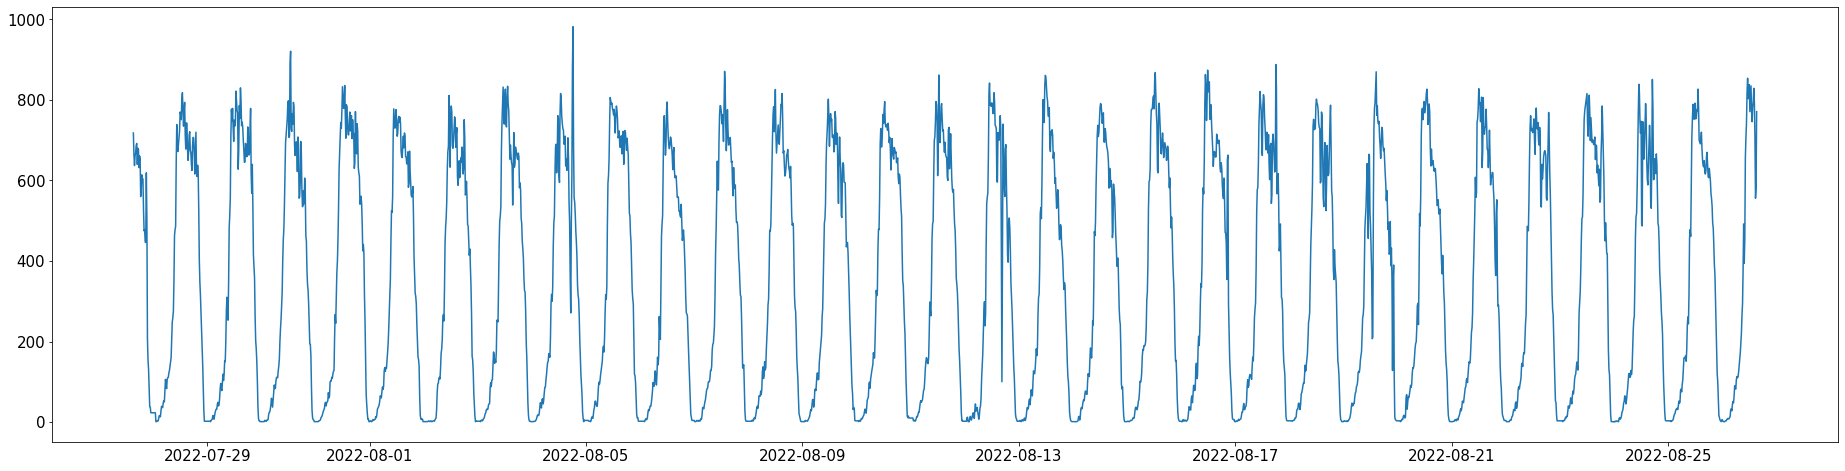

In [311]:
f = plt.figure()
f.set_size_inches(32,8)
plt.plot(dataframe.index,data) # x asis change

* looks like sine/cosine function with some noise

#### Time series decompasition   

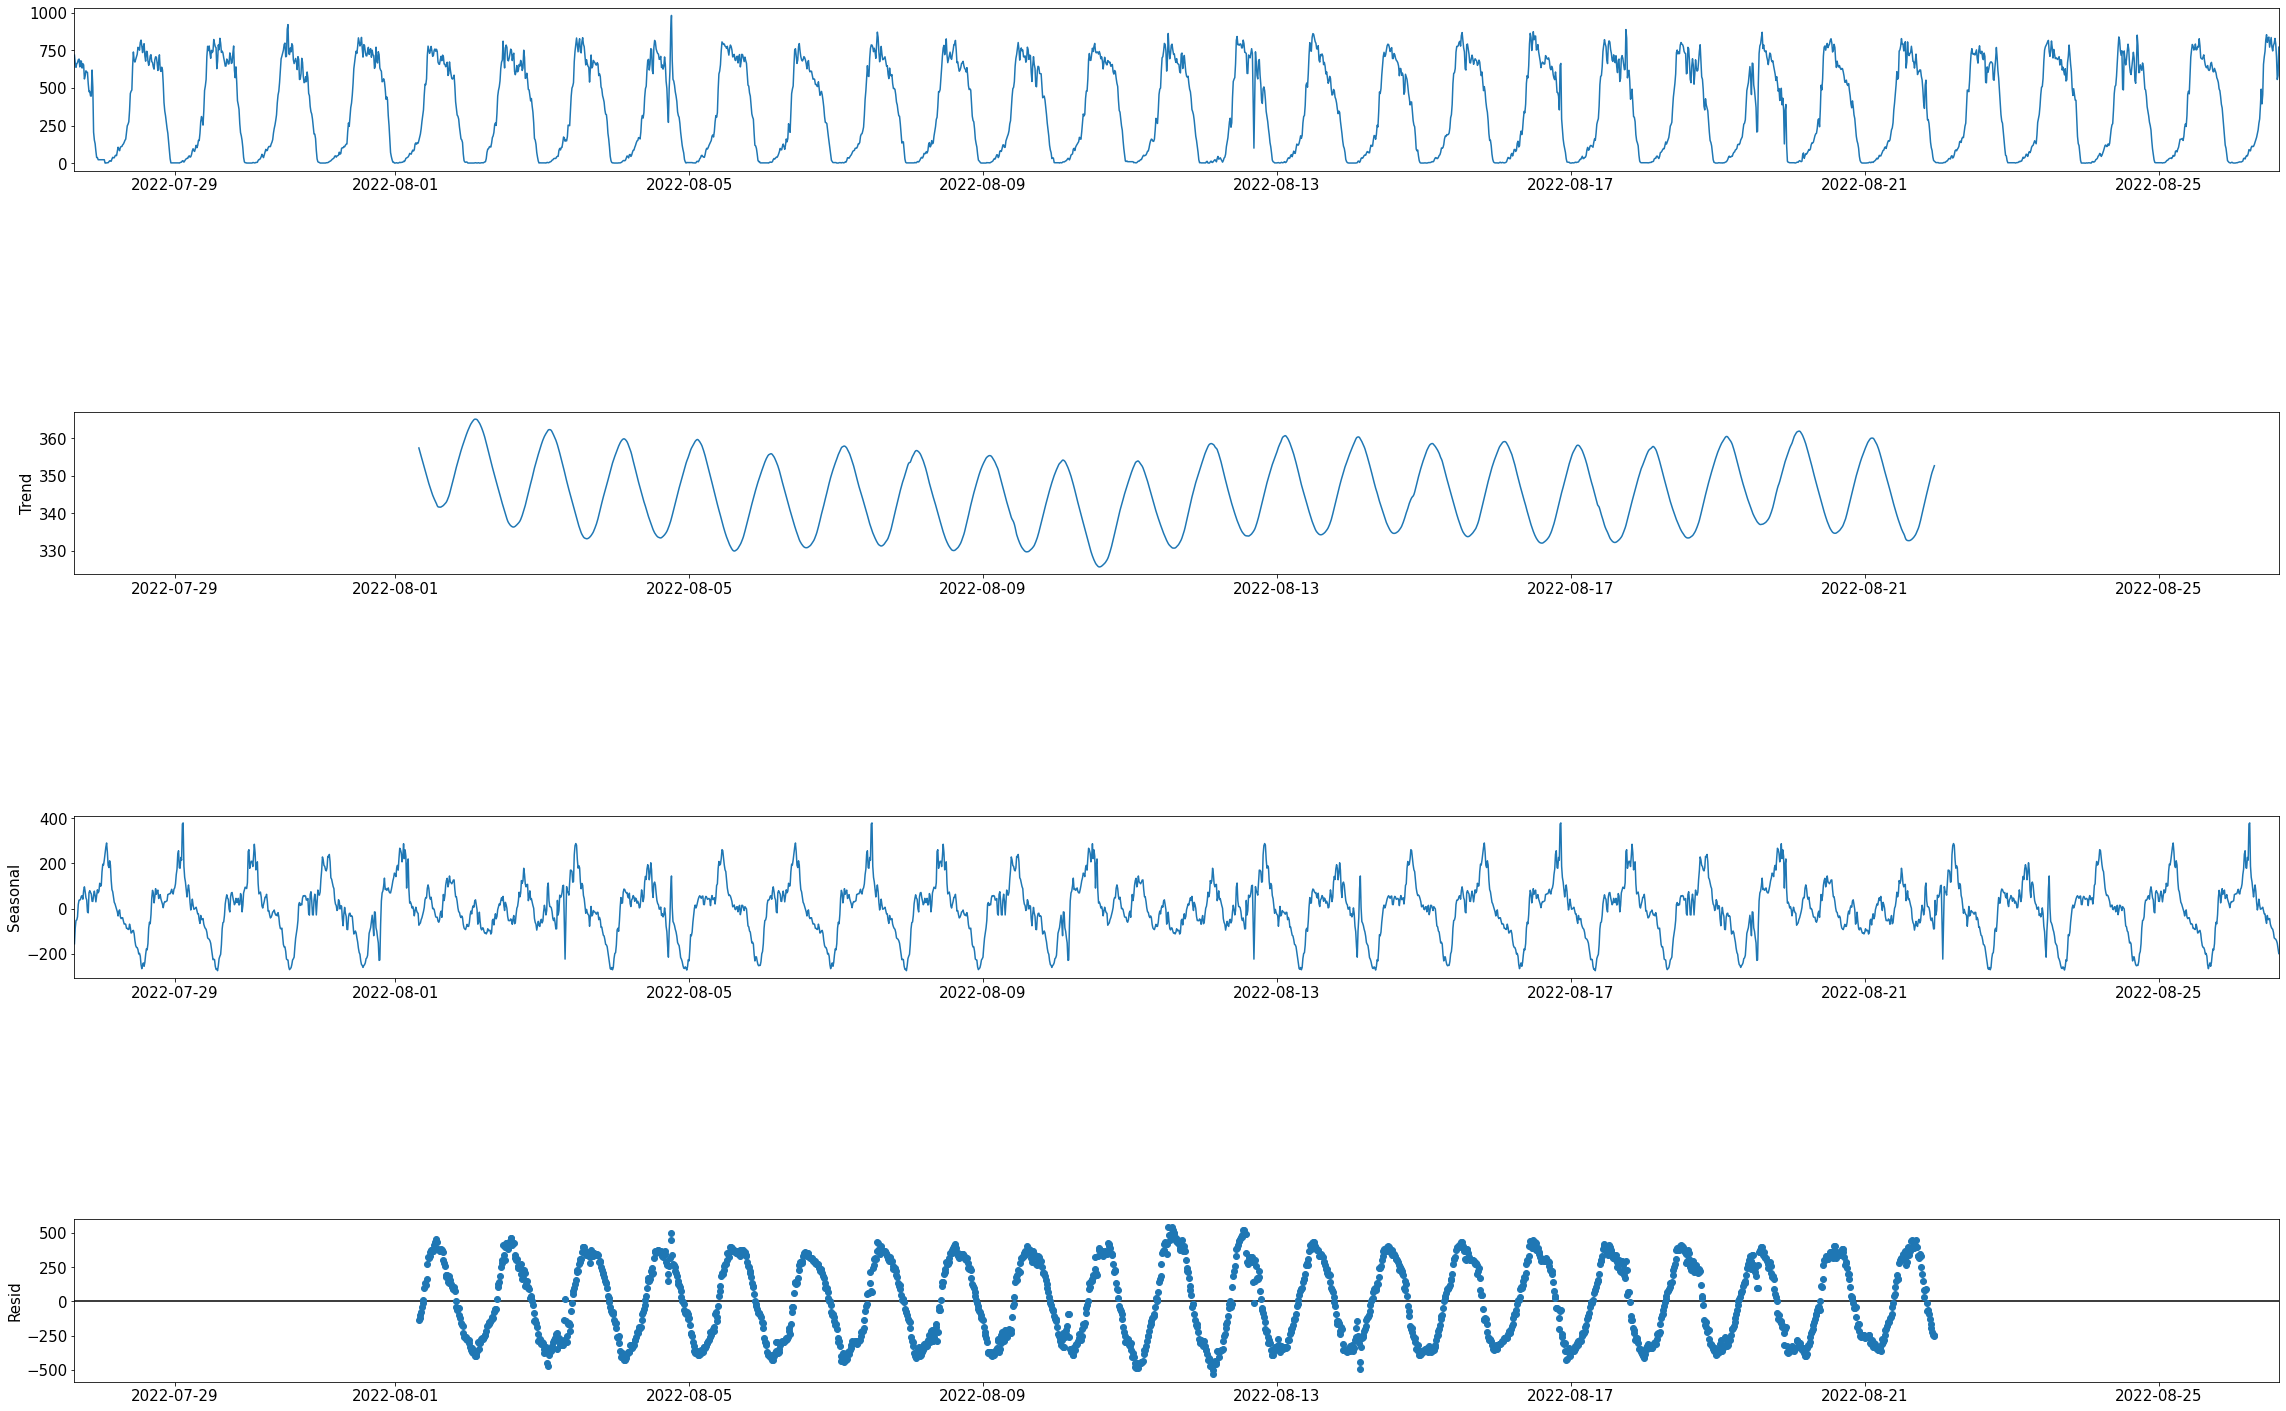

In [312]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(dataframe,period = 60*15)

fig = result.plot()
fig.set_size_inches(32,24)
plt.show()

* residual function looks like sine but not perfect, maybe these values are anomaly

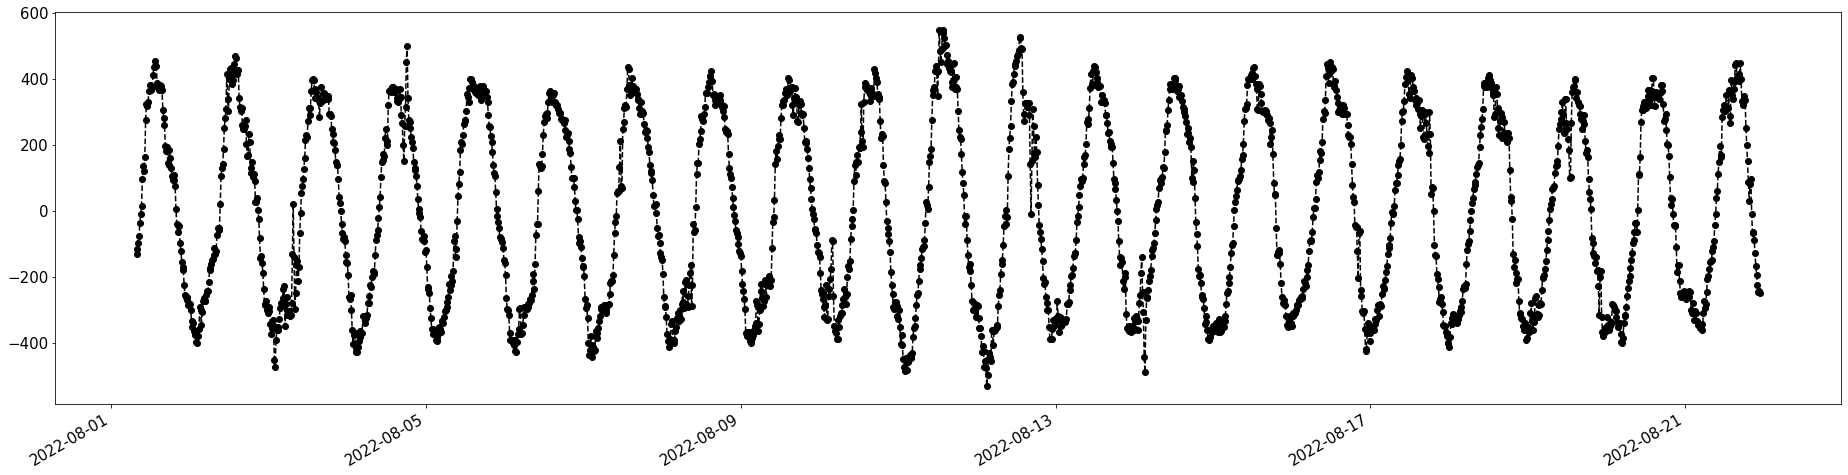

In [313]:
plt.rc('figure',figsize=(32,8))
plt.rc('font',size=15)
fig, ax = plt.subplots()
x_data = result.resid.index
y_data = result.resid.values
ax.plot_date(x_data, y_data, color='black',linestyle='--')
fig.autofmt_xdate()
plt.show()

* non-zero values percentage in residual:  

In [314]:
np.count_nonzero(~np.isnan(y_data))/len(y_data)

#remove all tailing nulls:
y_data = pd.Series(y_data)
last_valid = y_data[y_data.notnull()].index[-1]
y_curr = y_data.iloc[0:last_valid]

#remove all leading nulls:
first_valid = y_curr[y_curr.notnull()].index[0]
y_curr = y_curr.iloc[first_valid:]
y_curr.head()
print(y_curr.index[0])
print(y_curr)
print(y_curr.index[-1])
resid_df = pd.DataFrame()
resid_df.index = x_data[y_curr.index[0]:y_curr.index[-1] + 1]
resid_df['data'] = y_curr.values

450
450    -132.680074
451    -116.938222
452     -98.220630
453     -77.499889
454     -37.119704
           ...    
2425   -166.631185
2426   -194.104704
2427   -225.499889
2428   -245.792667
2429   -243.717667
Length: 1980, dtype: float64
2429


In [315]:
np.count_nonzero(~np.isnan(resid_df['data']))/len(resid_df['data'])

1.0

### Normalization of residual!!  

In [316]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(resid_df[['data']])
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))

y_normalized = scaler.transform(resid_df[['data']])

Min: -532.329889, Max: 546.470667


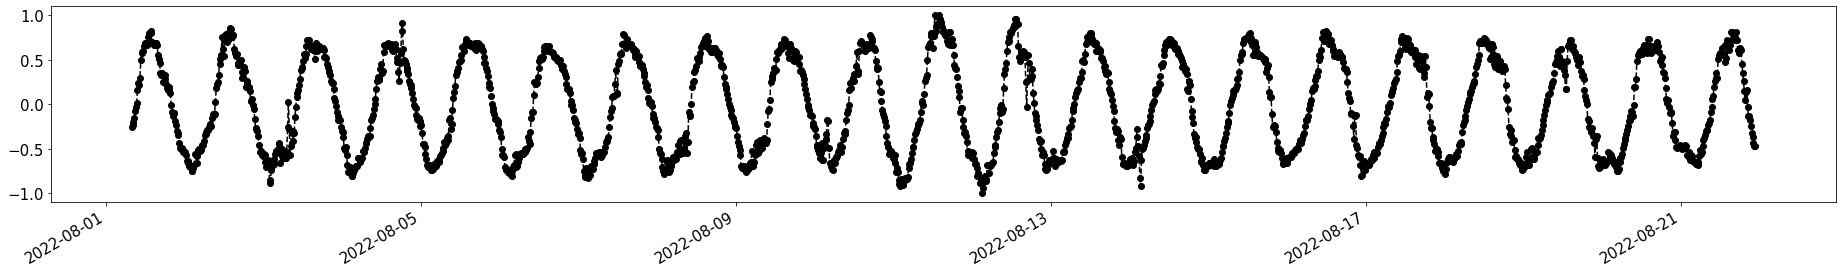

In [317]:
plt.rc('figure',figsize=(32,4))
plt.rc('font',size=15)
fig, ax = plt.subplots()
x_data = resid_df.index
y_data = y_normalized
ax.plot_date(x_data, y_data, color='black',linestyle='--')
fig.autofmt_xdate()
plt.show()

### get top 10 / 90 percentile set starting params properly

In [318]:
resid_df['data'] = y_normalized
print(np.percentile(y_normalized, 5))
print(np.percentile(y_normalized, 95))
y_normalized = y_normalized[:,0]

-0.7159555545484931
0.7282430693347187


### Train-test split  

In [319]:
TEST_PERCENTAGE = 0.2
test_size = int(TEST_PERCENTAGE * len(resid_df))
df_train = resid_df[:-test_size]
df_test = resid_df[-test_size:]

## Trying different models

### 1 model: Least squares fitting

In [320]:
from scipy import optimize
#guessed func
x_fit = np.linspace(0,100,len(df_train['data']))

def guessed_func(x, dist, amp, omega, phi):
    return dist + amp * np.cos(omega * x + phi)

params, params_covariance = optimize.curve_fit(guessed_func, x_fit, df_train['data'])

In [321]:
from IPython.display import display, Math
print('Fitted parameters:')
display(Math('a_0={:.2f}, a_1={:.2f}, \\omega={:.2f}, \\phi={:.2f}'.format(*params)))

Fitted parameters:


<IPython.core.display.Math object>

In [322]:
def comparing_plot(x, y_true, y_fitted):
    plt.plot(x, y_fitted, '*', label='Fittted data')
    plt.plot(x, y_true, '*', label='Real data')
    plt.legend()
    plt.show()

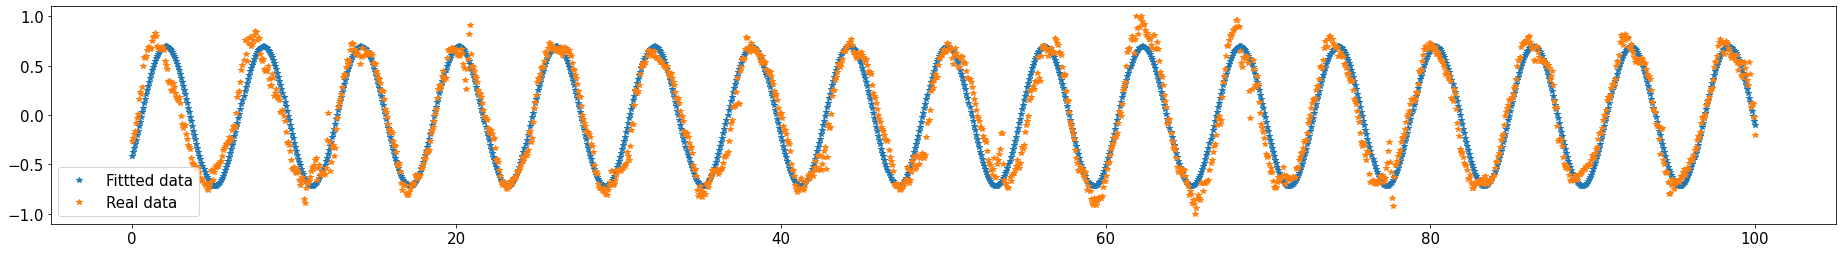

In [323]:
y_fit = [guessed_func(x_curr, *params) for x_curr in x_fit]
comparing_plot(x=x_fit, y_true=df_train['data'], y_fitted=y_fit)

#### Testing:

train error
RMSE=  90.15874022278818


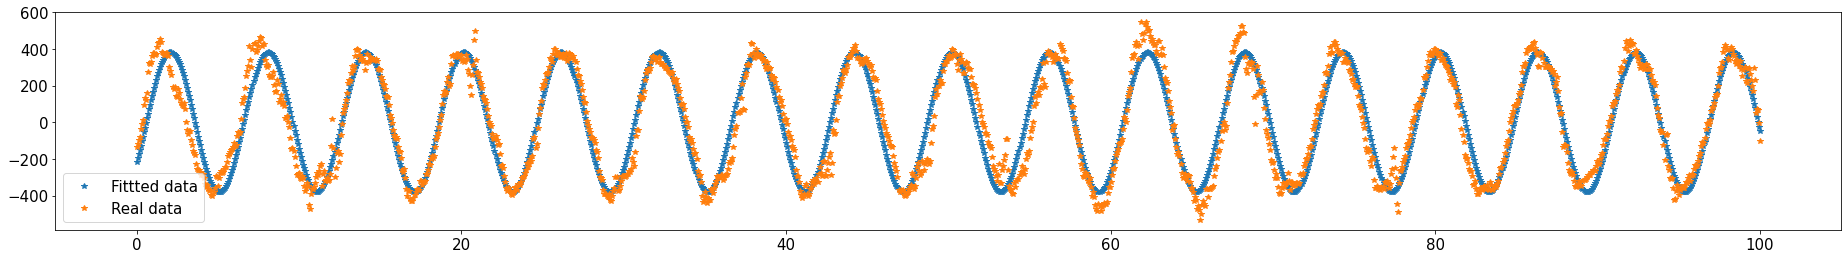

test error:
RMSE=  100.15377770374735


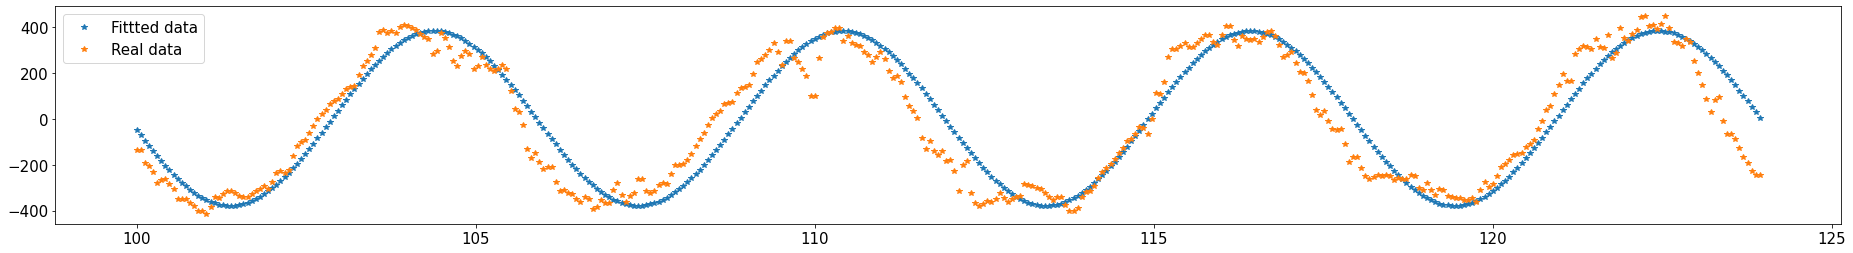

In [324]:
from sklearn.metrics import mean_squared_error

print('train error')
#scale data back:
y_true = scaler.inverse_transform([df_train['data']])
y_pred = scaler.inverse_transform([y_fit])
print("RMSE= ", mean_squared_error(y_true[0],y_pred[0],squared=False))
comparing_plot(x_fit, y_true[0], y_pred[0])

#Testing:
print('test error:')

# because x should be scaled proportional to dataframe size
x_test_fit = np.linspace(100,100//(1-TEST_PERCENTAGE),len(df_test['data']),endpoint=False)
y_test_fit = [guessed_func(x_curr, *params) for x_curr in x_test_fit]

y_true_test = scaler.inverse_transform([df_test['data']])
y_pred_test = scaler.inverse_transform([y_test_fit])
print("RMSE= ", mean_squared_error(y_true_test[0],y_pred_test[0],squared=False))
comparing_plot(x_test_fit, y_true_test[0], y_pred_test[0])

### Guessed as anomaly:  #TODO: concat train and test!

In [325]:
diff = abs(y_true[0] - y_pred[0])
treshold_value = pd.Series(diff).quantile(0.99)
anomaly_idicies = np.argwhere(diff > treshold_value).reshape(-1)

### 2 nd try, use Hyperopt

In [326]:
def objective(a0, a1, w, f):
    """Objective function to minimize"""
    return np.mean((a0+ a1 * np.cos(w*x_fit + f) - df_train['data'])**2)

def objective2(args):
    return objective(*args)
from hyperopt import hp, tpe, Trials, fmin
from IPython.display import display, Math

space = [hp.uniform('a0', -0.1, 0.1),
         hp.uniform('a1', 0.6, 0.8), 
         hp.uniform('w', 0, np.pi), 
         hp.uniform('f', -np.pi, np.pi)]

tpe_algo = tpe.suggest
tpe_trials = Trials()

tpe_best = fmin(fn=objective2, space=space, algo=tpe_algo, trials=tpe_trials, max_evals=500, rstate=np.random.default_rng(0))

print('Fitted parameters:')
display(Math('a_0={a0:.2f}, a_1={a1:.2f}, \\omega={w:.2f}, \\phi={f:.2f}'.format(**tpe_best)))


100%|██████████| 500/500 [00:10<00:00, 46.83trial/s, best loss: 0.051929466740085174]
Fitted parameters:


<IPython.core.display.Math object>

In [327]:
best_params = list(tpe_best.values())
#resolving w and phi mixup
best_params[2] = list(tpe_best.values())[3]
best_params[3] = list(tpe_best.values())[2]

-0.38610650985396583
0.2261728260278088


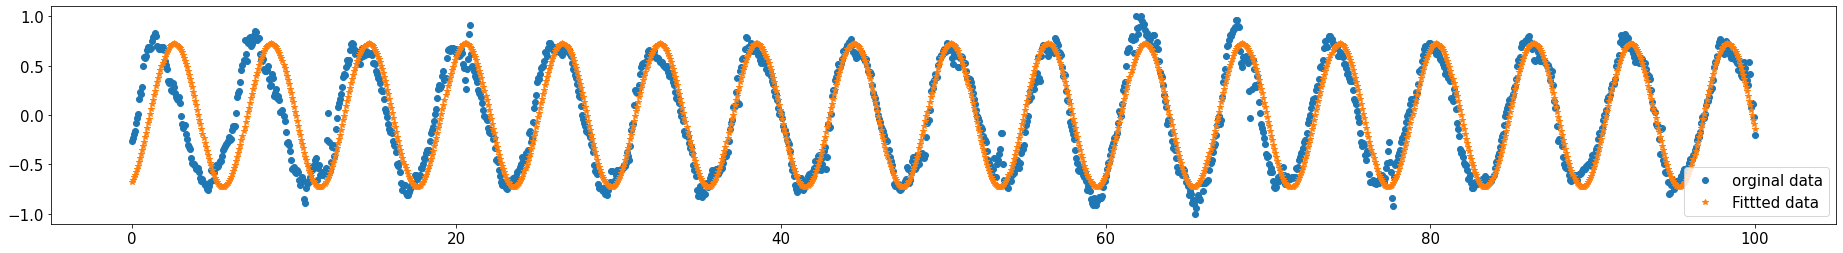

In [328]:
#x_fit = np.arange(0,len(df_train['data']))   #range of x values used for the fit function
y_fit = [guessed_func(x_curr, *best_params) for x_curr in x_fit]
print(y_fit[104])
print(df_train['data'][104])
plt.plot(x_fit, df_train['data'], 'o', label='orginal data')
plt.plot(x_fit, y_fit, '*', label='Fittted data')
plt.legend()
plt.show()